In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import datetime as dt
plt.rcParams["figure.figsize"] = (18, 6)

In [46]:
ba_beers = pd.read_csv('generated/new_ba_beers.csv')
ba_breweries = pd.read_csv('generated/new_ba_breweries.csv')
ba_users = pd.read_csv('generated/new_ba_users.csv')
ba_reviews = pd.read_parquet('generated/new_ba_reviews.parquet')

rb_beers = pd.read_csv('generated/new_rb_beers.csv')
rb_breweries = pd.read_csv('generated/new_rb_breweries.csv')
rb_users = pd.read_csv('generated/new_rb_users.csv')
rb_reviews = pd.read_parquet('generated/new_rb_reviews.parquet')

# Task - User activity : What can we say about the activity of reviewers

## Group reviews per user

In [48]:
ba_users['user_id'] = ba_users['user_id'].astype(str)
rb_users['user_id'] = rb_users['user_id'].astype(str)
ba_reviews['user_id'] = ba_reviews['user_id'].astype(str)
rb_reviews['user_id'] = rb_reviews['user_id'].astype(str)

ba_users = ba_users.set_index('user_id')
rb_users = rb_users.set_index('user_id')

ba_reviews_per_user = ba_reviews.groupby('user_id')
rb_reviews_per_user = rb_reviews.groupby('user_id')

## Features definition
1) total number of reviews
2) time since registration
3) diversity of beer styles/types
4) predilection toward a beer style/type
5)  consistency (engagement habits) : frequency mean + std

### BeerAdvocate features

In [90]:
# 1. total nb of reviews
ba_total_reviews = ba_reviews_per_user['beer_id'].count().rename('total_reviews')

# 2. time since registration (until last activity recorded)
last_review_date = (pd.to_datetime(ba_reviews['date'], dayfirst=True)).max()
last_review_days = (last_review_date - pd.Timestamp('1970-01-01')).days
joined_days = (pd.to_datetime(ba_users['joined'], dayfirst=True) - pd.Timestamp('1970-01-01')).dt.days
ba_usage_duration = (last_review_days - joined_days).rename('usage_duration')


# 3. style diversity
ba_style_diversity = ba_reviews_per_user['style'].nunique().rename('style_diversity')

# 4. style predilection
ba_style_count = ba_reviews_per_user["style"].value_counts().groupby('user_id')
ba_predilection_ratio = (ba_style_count.max()/ba_total_reviews).rename('predilection_ratio')

# 5. consistency
ba_reviews_sorted = ba_reviews[['user_id','date']].copy()
ba_reviews_sorted.set_index('user_id',inplace=True)
ba_reviews_sorted['date'] = pd.to_datetime(ba_reviews_sorted['date'], dayfirst=True)
ba_reviews_sorted.sort_values('date', inplace=True)
time_spacings = ba_reviews_sorted.groupby('user_id')['date'].apply(lambda x : x.diff().dt.days).dropna()
ba_mean_time_spacing = (
    time_spacings.groupby('user_id').mean().rename('mean_time_spacing')
)
ba_std_time_spacing = (
    time_spacings.groupby('user_id').std().rename('std_time_spacing')
)

In [91]:
ba_features = (
    ba_total_reviews
    .to_frame()
    .merge(ba_usage_duration, on='user_id', how="outer")
    .merge(ba_style_diversity, on='user_id', how="outer")
    .merge(ba_predilection_ratio, on='user_id', how="outer")
    .merge(ba_mean_time_spacing, on='user_id', how="outer")
    .merge(ba_std_time_spacing, on='user_id', how="outer")
) #.fillna(0)

ba_features.head()

,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing
user_id,,,,,,
-----kiki-----.1000245,NaN,778.0,NaN,NaN,NaN,NaN
---.940711,NaN,906.0,NaN,NaN,NaN,NaN
--dida--.1042029,NaN,688.0,NaN,NaN,NaN,NaN
--dom--.709199,16.0,1683.0,10.0,0.1875,82.8,174.050978
--nomad--.931404,NaN,922.0,NaN,NaN,NaN,NaN


### RateBeer features

In [92]:
# 1. total nb of reviews
rb_total_reviews = rb_reviews_per_user['beer_id'].count().rename('total_reviews')

# 2. time since registration (until last activity recorded)
last_review_date = (pd.to_datetime(rb_reviews['date'], dayfirst=True)).max()
last_review_days = (last_review_date - pd.Timestamp('1970-01-01')).days
joined_days = (pd.to_datetime(rb_users['joined'], dayfirst=True) - pd.Timestamp('1970-01-01')).dt.days
rb_usage_duration = (last_review_days - joined_days).rename('usage_duration')


# 3. style diversity
rb_style_diversity = rb_reviews_per_user['style'].nunique().rename('style_diversity')

# 4. style predilection
rb_style_count = rb_reviews_per_user["style"].value_counts().groupby('user_id')
rb_predilection_ratio = (rb_style_count.max()/rb_total_reviews).rename('predilection_ratio')

# 5. consistency
rb_reviews_sorted = rb_reviews[['user_id','date']].copy()
rb_reviews_sorted.set_index('user_id',inplace=True)
rb_reviews_sorted['date'] = pd.to_datetime(rb_reviews_sorted['date'], dayfirst=True)
rb_reviews_sorted.sort_values('date', inplace=True)
time_spacings = rb_reviews_sorted.groupby('user_id')['date'].apply(lambda x : x.diff().dt.days).dropna()
rb_mean_time_spacing = (
    time_spacings.groupby('user_id').mean().rename('mean_time_spacing')
)
rb_std_time_spacing = (
    time_spacings.groupby('user_id').std().rename('std_time_spacing')
)

In [93]:
rb_features = (
    rb_total_reviews
    .to_frame()
    .merge(rb_usage_duration, on='user_id', how="outer")
    .merge(rb_style_diversity, on='user_id', how="outer")
    .merge(rb_predilection_ratio, on='user_id', how="outer")
    .merge(rb_mean_time_spacing, on='user_id', how="outer")
    .merge(rb_std_time_spacing, on='user_id', how="outer")
) #.fillna(0)

rb_features.head()

,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing
user_id,,,,,,
10,5.0,6319.0,4.0,0.400000,19.250000,21.468970
100007,73.0,2757.0,32.0,0.150685,31.930556,83.542235
100011,46.0,2757.0,24.0,0.195652,16.044444,71.228810
100012,30.0,2757.0,20.0,0.133333,63.103448,233.109316
100021,1.0,2757.0,1.0,1.000000,NaN,NaN


## Data preprocessing

In [94]:
# Drop 'user_id' + 'predilection_style' columns
ba_features_cleaned = ba_features.copy()
# Deal with NaN values
ba_features_cleaned.dropna(inplace=True)

# Standardize
#ba_scaler = StandardScaler()
#ba_features_scaled = ba_scaler.fit_transform(ba_features_cleaned)

ba_scaler = StandardScaler()
ba_features_scaled = ba_scaler.fit_transform(ba_features_cleaned)
ba_features_scaled = pd.DataFrame(ba_features_scaled, columns=ba_features_cleaned.columns, index=ba_features_cleaned.index)

In [60]:
# Drop 'user_id' + 'predilection_style' columns
rb_features_cleaned = rb_features.copy()
# Deal with NaN values
rb_features_cleaned.dropna(inplace=True)

# Standardize
#ba_scaler = StandardScaler()
#ba_features_scaled = ba_scaler.fit_transform(ba_features_cleaned)

rb_scaler = StandardScaler()
rb_features_scaled = rb_scaler.fit_transform(rb_features_cleaned)
rb_features_scaled = pd.DataFrame(rb_features_scaled, columns=rb_features_cleaned.columns, index=rb_features_cleaned.index)

## Dimensionality reduction (PCA)

In [95]:
#print(f"Variance by original features: {ba_features_scaled.var()}")

pca = PCA(n_components=0.95)  # Retain 95% of variance
PCs = pca.fit_transform(ba_features_scaled)
ba_features_reduced = pd.DataFrame(PCs, index=ba_features_scaled.index, columns=[f"PC{i+1}" for i in range(PCs.shape[1])])
print(f"Explained variance by components: {pca.explained_variance_ratio_}")

Explained variance by components: [0.41306229 0.30670772 0.13902074 0.0988965 ]


In [70]:
#print(f"Variance by original features: {rb_features_scaled.var()}")

pca = PCA(n_components=0.95)  # Retain 95% of variance
PCs = pca.fit_transform(rb_features_scaled)
rb_features_reduced = pd.DataFrame(PCs, index=rb_features_scaled.index, columns=[f"PC{i+1}" for i in range(PCs.shape[1])])
print(f"Explained variance by components: {pca.explained_variance_ratio_}")

Explained variance by components: [0.35574007 0.28482851 0.16057058 0.12847969 0.05441205]


## Number of clusters (silhouette score + elbow method)

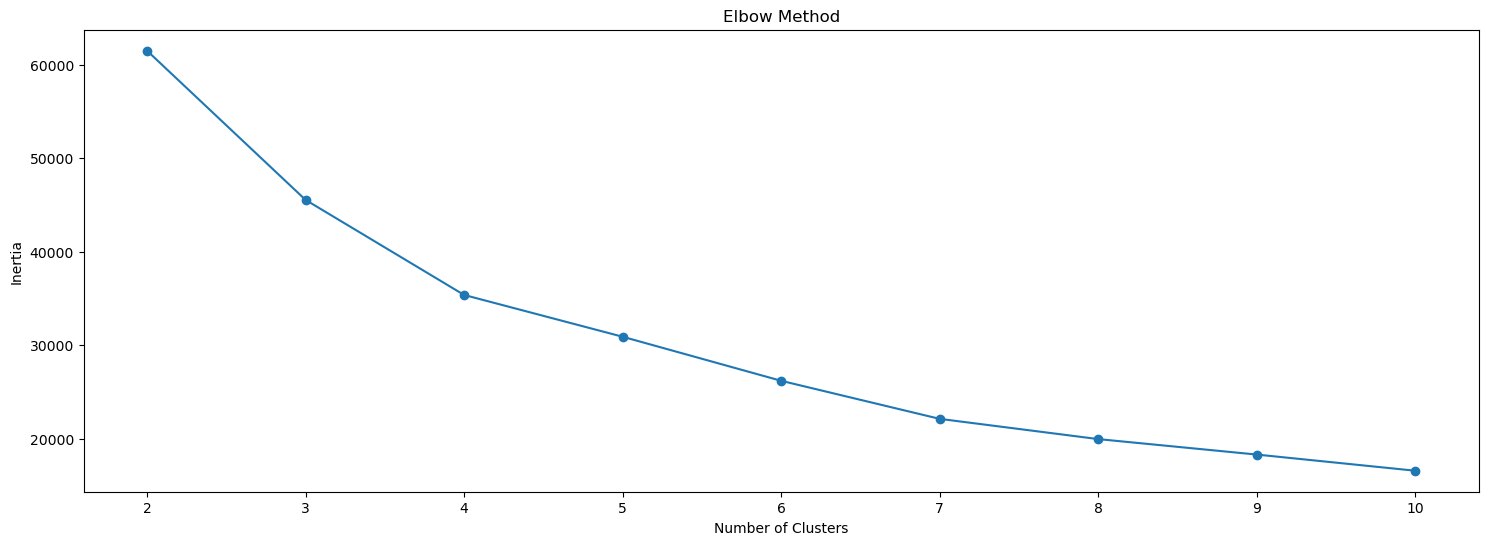

Silhouette Score for 2 clusters: 0.38021241109313436
Silhouette Score for 3 clusters: 0.420763061373723
Silhouette Score for 4 clusters: 0.29669565658857494
Silhouette Score for 5 clusters: 0.277703319511852
Silhouette Score for 6 clusters: 0.28959468110889475
Silhouette Score for 7 clusters: 0.2997778034108641
Silhouette Score for 8 clusters: 0.27932308101404146
Silhouette Score for 9 clusters: 0.2800433819941713
Silhouette Score for 10 clusters: 0.28384989467309035


In [96]:
# Elbow Method
inertia = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ba_features_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(ba_features_reduced)
    score = silhouette_score(ba_features_reduced, labels)
    print(f"Silhouette Score for {k} clusters: {score}")



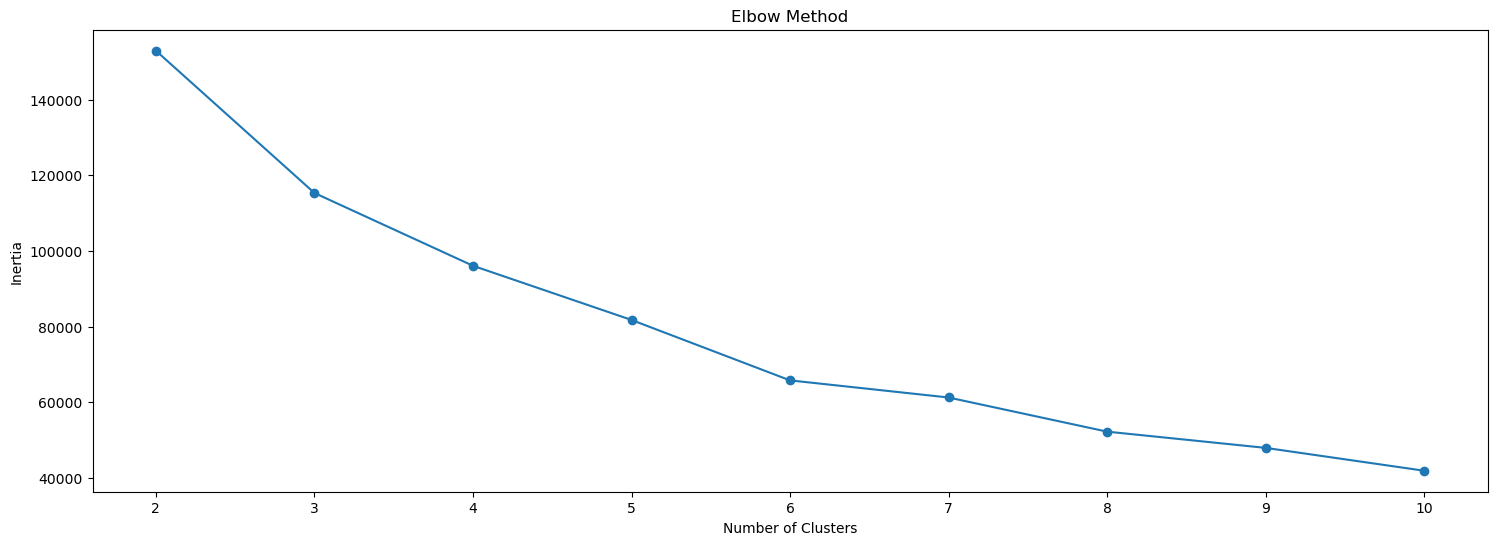

Silhouette Score for 2 clusters: 0.35023790062633076
Silhouette Score for 3 clusters: 0.39505881508366203
Silhouette Score for 4 clusters: 0.3198941334148653
Silhouette Score for 5 clusters: 0.3294151317402538
Silhouette Score for 6 clusters: 0.3450905598471959
Silhouette Score for 7 clusters: 0.3219959759212294
Silhouette Score for 8 clusters: 0.32913995583352396
Silhouette Score for 9 clusters: 0.32948426291616084
Silhouette Score for 10 clusters: 0.35148195981011626


In [71]:
# Elbow Method
inertia = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rb_features_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rb_features_reduced)
    score = silhouette_score(rb_features_reduced, labels)
    print(f"Silhouette Score for {k} clusters: {score}")


In [72]:
n_clusters = 3

## Clustering

In [97]:
# Clustering for ba
ba_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
ba_cluster_labels = ba_kmeans.fit_predict(ba_features_reduced)
#ba_features['cluster'] = np.nan
#ba_features.loc[ba_features_reduced.index, 'cluster'] = ba_cluster_labels
ba_cluster_labels_series = pd.Series(ba_cluster_labels, index=ba_features_reduced.index, name='cluster')
if 'cluster' not in ba_features.columns:
    ba_features = ba_features.join(ba_cluster_labels_series, how='left')
ba_features.head(30)

,total_reviews,usage_duration,style_diversity,predilection_ratio,mean_time_spacing,std_time_spacing,cluster
user_id,,,,,,,
-----kiki-----.1000245,NaN,778.0,NaN,NaN,NaN,NaN,NaN
---.940711,NaN,906.0,NaN,NaN,NaN,NaN,NaN
--dida--.1042029,NaN,688.0,NaN,NaN,NaN,NaN,NaN
--dom--.709199,16.0,1683.0,10.0,0.187500,82.800000,174.050978,2.0
--nomad--.931404,NaN,922.0,NaN,NaN,NaN,NaN,NaN
--weezl--.789708,1.0,1229.0,1.0,1.000000,NaN,NaN,NaN
-1x.1006554,NaN,765.0,NaN,NaN,NaN,NaN,NaN
-a-.792722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-apex-.882418,NaN,1013.0,NaN,NaN,NaN,NaN,NaN


In [89]:
#ba_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#ba_features["cluster"] = ba_kmeans.fit_predict(ba_features_scaled)

# Clustering for RB
rb_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rb_cluster_labels = rb_kmeans.fit_predict(rb_features_reduced)
#rb_features['cluster'] = np.nan
#rb_features.loc[rb_features_reduced.index, 'cluster'] = rb_cluster_labels
rb_cluster_labels_series = pd.Series(rb_cluster_labels, index=rb_features_reduced.index, name='cluster')
if 'cluster' not in rb_features.columns:
    rb_features = rb_features.join(rb_cluster_labels_series, how='left')
rb_features.head(30)

,total_reviews,usage_duration,style_diversity,predilection_ration,mean_time_spacing,std_time_spacing,cluster
user_id,,,,,,,
10,5.0,6319.0,4.0,0.400000,19.250000,21.468970,0.0
100007,73.0,2757.0,32.0,0.150685,31.930556,83.542235,0.0
100011,46.0,2757.0,24.0,0.195652,16.044444,71.228810,0.0
100012,30.0,2757.0,20.0,0.133333,63.103448,233.109316,0.0
100021,1.0,2757.0,1.0,1.000000,NaN,NaN,NaN
100022,7.0,2757.0,6.0,0.285714,0.000000,0.000000,0.0
100023,2.0,2757.0,2.0,0.500000,0.000000,NaN,NaN
100029,237.0,2756.0,53.0,0.063291,7.025424,66.544749,1.0
100052,3.0,2756.0,3.0,0.333333,195.000000,275.771645,0.0


## Evaluation and Visualization

In [81]:
print(f"Inertia: {rb_kmeans.inertia_:.2f}")

from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(rb_features_reduced, rb_features['cluster'].dropna().astype(int))
print(f"Davies-Bouldin Index: {db_score:.3f}")

Inertia: 115332.63


ValueError: Found input variables with inconsistent numbers of samples: [32832, 34528]

In [82]:
plt.figure(figsize=(8, 6))
plt.scatter(rb_features_reduced[:, 0], rb_features_reduced[:, 1], c=rb_features['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualized in PCA Space')
plt.show()


tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(rb_features_reduced)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=rb_features['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('Clusters Visualized in TSNE Space')
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 800x600 with 0 Axes>

## Analysis

         total_reviews  usage_duration  style_diversity  predilection_ration  \
cluster                                                                        
0.0          17.031618     2331.141606         8.668246             0.328551   
1.0         827.072010     3313.203576        52.461406             0.110564   
2.0           6.500000     3204.870597         5.026799             0.346864   

         mean_time_spacing  std_time_spacing  
cluster                                       
0.0              23.763441         42.823644  
1.0               5.295011         20.716851  
2.0             387.177312        588.045767  


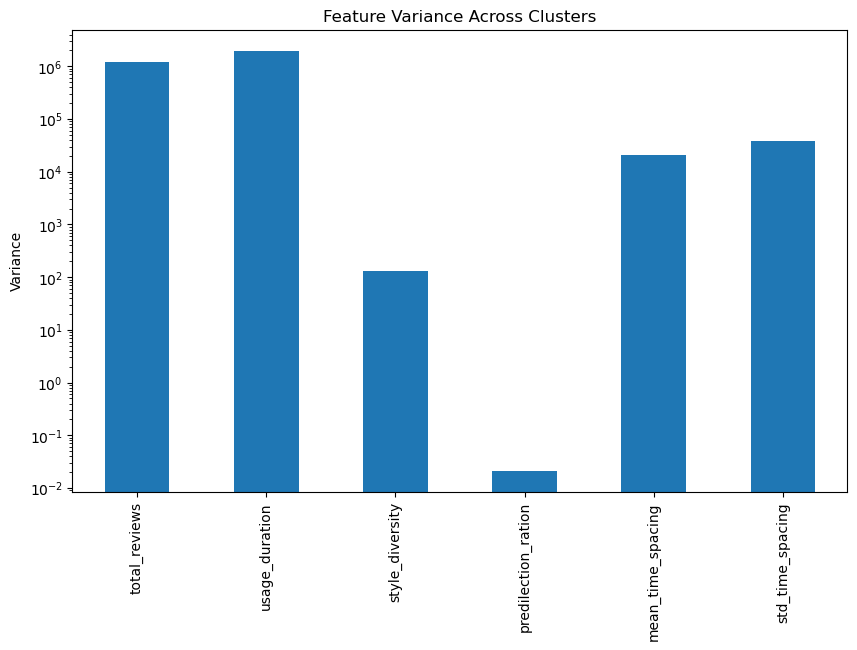

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0.0,25112.0,17.031618,27.735387,3.0,4.0,7.0,17.0,660.0
1.0,8110.0,827.072010,1919.196155,26.0,77.0,230.0,734.0,43251.0
2.0,1306.0,6.500000,5.186078,3.0,3.0,5.0,7.0,42.0


In [84]:
cluster_summary = rb_features.groupby('cluster').mean()
print(cluster_summary)

feature_variance = rb_features.groupby('cluster').var().mean()

feature_variance.plot(kind='bar', figsize=(10, 6), title='Feature Variance Across Clusters')
plt.ylabel('Variance')
plt.yscale('log')
plt.show()

rb_features.groupby('cluster')['total_reviews'].describe()